In [1]:
from matplotlib import pyplot as plt

In [2]:
import netcomp as nc

# use if making graphics for a presentation
plt.style.use(['classic','ggplot'])

figures_dir = '/Users/peterwills/google-drive/Research/Graph Distance Study/metrics_paper/figures'

In [3]:
%%bash
cd data
curl -O http://konect.cc/files/download.tsv.dnc-temporalGraph.tar.bz2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162k  100  162k    0     0   161k      0  0:00:01  0:00:01 --:--:--  161k
gunzip: can't stat: CollegeMsg.txt.gz (CollegeMsg.txt.gz.gz): No such file or directory


CalledProcessError: Command 'b'cd data\ncurl -O http://konect.cc/files/download.tsv.dnc-temporalGraph.tar.bz2\ngunzip CollegeMsg.txt.gz\n\n# grab metadata too\n'' returned non-zero exit status 1.

In [4]:
import pandas as pd

In [5]:
full_data = pd.read_csv('./data/dnc.tsv',sep='\t',header=None)

In [6]:
full_data.head()

,0,1,2,3
0,419,465,1,1463507482
1,869,453,1,1462337903
2,943,1151,1,1463167636
3,943,217,1,1463167636
4,943,841,1,1463167636


In [7]:
full_data.columns = ['i','j','vol', 'ts']

In [8]:
from datetime import datetime

In [9]:
full_data['dt'] = full_data['ts'].apply(datetime.fromtimestamp)

In [10]:
full_data['day'] = full_data['dt'].apply(lambda x: x.date())

In [15]:
data = full_data[full_data['day'] > pd.to_datetime('2016-04-01')]

Text(0.5, 1.0, 'message volume by day')

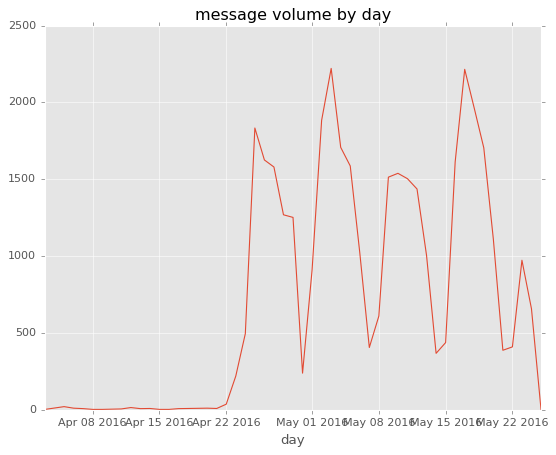

In [16]:
data.groupby('day').count()['ts'].plot()
plt.title('message volume by day')

In [17]:
import networkx as nx

In [29]:
graphs = []
amats = []
amats_clean = []

all_ids = list(full_data['i']) + list(full_data['j'])
days = []

for day, df in data.groupby('day'):
    days.append(day)
    G = nx.Graph()
    G.add_nodes_from(all_ids)
    G.add_edges_from(zip(df['i'],df['j']))
    graphs.append(G)
    amats.append(nx.adjacency_matrix(G))
    G.remove_nodes_from(nx.isolates(G))
    amats_clean.append(nx.adjacency_matrix(G))

# Analysis

Let's take the renormalized resistance distance between each graph, along with the edit distance, and see what we can see.

In [20]:
def vol_dist(A1,A2):
    """Volume difference between two graphs."""
    return np.abs(A1.sum() - A2.sum())/2

In [21]:
import numpy as np

In [22]:
from tqdm import tqdm

In [24]:
len(amats)

51

In [32]:
days = days[1:]

In [25]:
%%time

r_dists = []
e_dists = []
d_dists = []
ns_dists = []
adj_dists = []
lap_dists = []
nlap_dists = []
vol_dists = []

for A_old,A in tqdm(zip(amats[:-1],amats[1:])):
    r_dists.append(nc.resistance_distance(A,A_old,renormalized=True))
    e_dists.append(nc.edit_distance(A,A_old))
    d_dists.append(nc.deltacon0(A,A_old))
    ns_dists.append(nc.netsimile(A,A_old))
    adj_dists.append(nc.lambda_dist(A,A_old,kind='adjacency'))
    lap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian'))
    nlap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian_norm'))
    vol_dists.append(vol_dist(A,A_old))


0it [00:00, ?it/s]
1it [00:06,  6.79s/it]
2it [00:13,  6.81s/it]
3it [00:20,  6.84s/it]
4it [00:27,  6.80s/it]
5it [00:34,  6.95s/it]
6it [00:42,  7.10s/it]
7it [00:48,  7.04s/it]
8it [00:56,  7.12s/it]
9it [01:03,  7.09s/it]
10it [01:10,  7.17s/it]
11it [01:18,  7.24s/it]
12it [01:25,  7.26s/it]
13it [01:32,  7.19s/it]
14it [01:39,  7.13s/it]
15it [01:46,  7.11s/it]
16it [01:53,  7.09s/it]
17it [02:00,  7.15s/it]
18it [02:09,  7.64s/it]
19it [02:17,  7.87s/it]
20it [02:27,  8.50s/it]
21it [02:36,  8.40s/it]
22it [02:44,  8.43s/it]
23it [02:52,  8.34s/it]
24it [03:00,  8.10s/it]
25it [03:07,  7.93s/it]
26it [03:15,  7.98s/it]
27it [03:24,  8.03s/it]
28it [03:31,  7.96s/it]
29it [03:39,  7.98s/it]
30it [03:47,  7.90s/it]
31it [03:55,  7.78s/it]
32it [04:02,  7.64s/it]
33it [04:09,  7.56s/it]
34it [04:17,  7.59s/it]
35it [04:25,  7.64s/it]
36it [04:33,  7.71s/it]
37it [04:41,  7.91s/it]
38it [04:49,  7.83s/it]
39it [04:56,  7.72s/it]
40it [05:04,  7.67s/it]
41it [05:11,  7.66s/it]
42it 

CPU times: user 12min 42s, sys: 1min 20s, total: 14min 2s
Wall time: 6min 23s


In [26]:
# normalize by sample mean
r_dists = r_dists/np.mean(r_dists)
e_dists = e_dists/np.mean(e_dists)
d_dists = d_dists/np.mean(d_dists)
ns_dists = ns_dists/np.mean(ns_dists)
adj_dists = adj_dists/np.mean(adj_dists)
lap_dists = lap_dists/np.mean(lap_dists)
nlap_dists = nlap_dists/np.mean(nlap_dists)
vol_dists = vol_dists/np.mean(vol_dists)

In [27]:
# iterable of colors to use for anomaly indicators
color_list = ['#1f77b4','#ff7f0e','#2ca02c','#d6272b','#9467bd','#8c564b','#e377c2']
# these are matplotlib.patch.Patch properties
# see https://matplotlib.org/users/recipes.html
props = [dict(boxstyle='round',color=color) for color in color_list]

# Volume DIfference

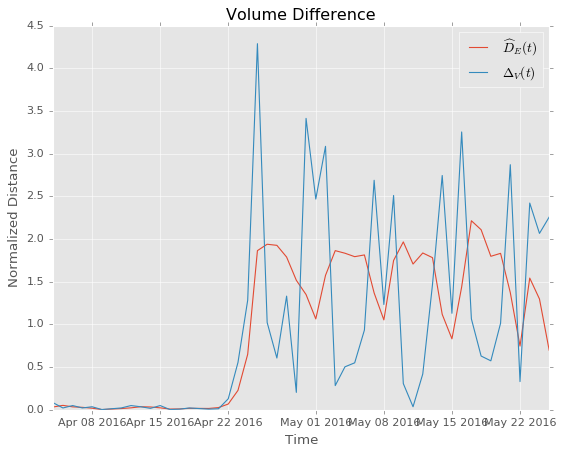

In [33]:
# plot curves
plt.plot(days,e_dists,label='$\widehat{D}_E(t)$');
plt.plot(days,vol_dists,label='$\Delta_V(t)$');
plt.xlabel('Time');
plt.ylabel('Normalized Distance');
plt.title('Volume Difference');
plt.legend();

# fig = plt.gcf();
# fig.savefig(os.path.join(figures_dir,'primary_school_matrix.pdf'),
#             dpi=300,bbox_inches='tight');

# Matrix Distances

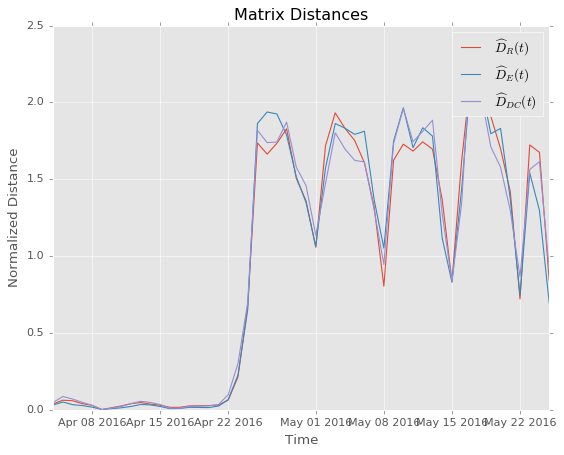

In [34]:

# plot curves
plt.plot(days,r_dists,label='$\widehat{D}_R(t)$');
plt.plot(days,e_dists,label='$\widehat{D}_E(t)$');
plt.plot(days,d_dists,label='$\widehat{D}_{DC}(t)$');

plt.xlabel('Time');
plt.ylabel('Normalized Distance');
plt.title('Matrix Distances');
plt.legend();

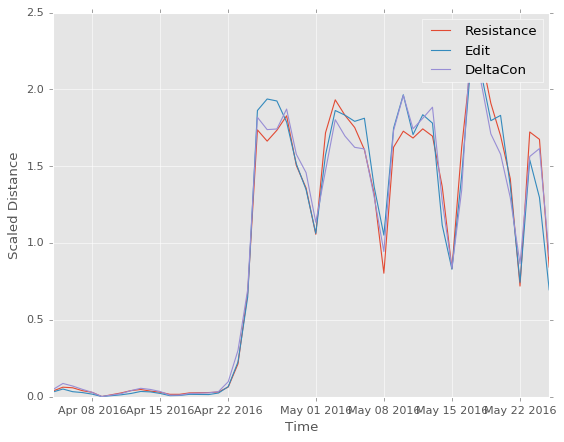

In [35]:

# plot curves
plt.plot(days,r_dists,label='Resistance');
plt.plot(days,e_dists,label='Edit');
plt.plot(days,d_dists,label='DeltaCon');

plt.xlabel('Time');
plt.ylabel('Scaled Distance');
plt.legend();

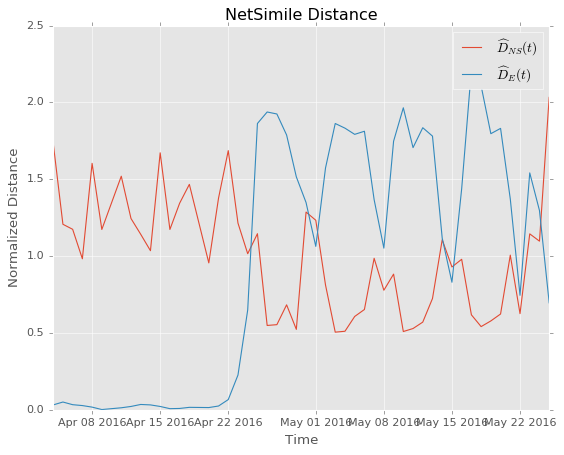

In [38]:

# plot curves
plt.plot(days,ns_dists,label='$\widehat{D}_{NS}(t)$');
plt.plot(days,e_dists,label='$\widehat{D}_E(t)$');


plt.xlabel('Time');
plt.ylabel('Normalized Distance');
plt.title('NetSimile Distance');
plt.legend(loc='upper left');
plt.legend();

# Lambda Distances

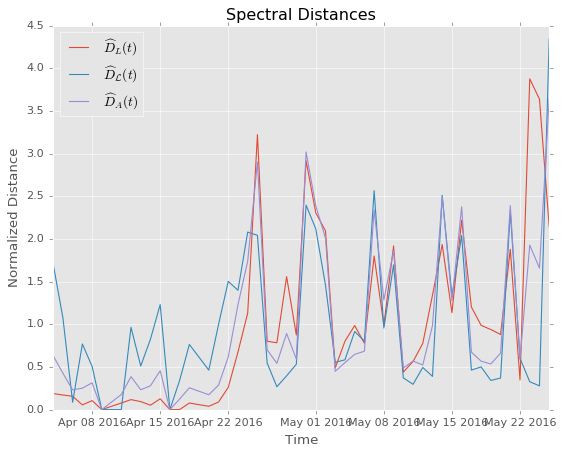

In [37]:

# plot curves
plt.plot(days,lap_dists,label='$\widehat{D}_{L}(t)$');
plt.plot(days,nlap_dists,label='$\widehat{D}_{\mathcal{L}}(t)$');
plt.plot(days,adj_dists,label='$\widehat{D}_{A}(t)$');

# axes labels & title
plt.xlabel('Time');
plt.ylabel('Normalized Distance');
plt.title('Spectral Distances');
plt.legend(loc='upper left');